+ Manage to convert the current code into a function in python s.t. one can just output everything by calling a function f(x,y,z,...) where x,y,z,... are hyperparameters. Without this, now one has to run the whole script when changing any parameter.

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"#否则内核时常挂掉
import torch
import torch.nn as nn
from time import perf_counter
from PIL import Image
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import requests

import matplotlib.animation as animation
from IPython.display import HTML
# check if GPU is available and use it; otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# IC
uv = np.mat([1,0]).T
uvo = torch.tensor(uv)
print('uvo =',uvo)

###################### hyperparameters ######################
neurons=10# neurons in hidden layer
batchsize = 500 # how many points to use per epoch
learnrate=0.01

###################### fixed parameters ######################
tspan = np.linspace(0, 2*np.pi, 500)[:, None]
t=torch.linspace(0, 2*np.pi, batchsize).reshape(-1,1)
uA = np.cos(tspan)
vA = np.sin(tspan)
NN = nn.Sequential(nn.Linear(1, neurons), nn.Sigmoid(), nn.Linear(neurons, 2, bias=False))
adam = torch.optim.Adam(NN.parameters(), lr=learnrate)

UV = lambda t: uvo + (t* NN(t)).mT
f = lambda t: torch.matmul(torch.tensor([[0,1],[-1,0]],dtype=torch.float), UV(t))

#call loss function independently
def loss(t):
    t.requires_grad_(True)
    UVot=UV(t)
    duvdt1=torch.autograd.grad(UVot[0].T,t,grad_outputs=torch.ones_like(UVot[0].T), create_graph=True)[0]
    duvdt2=torch.autograd.grad(UVot[1].T,t,grad_outputs=torch.ones_like(UVot[1].T), create_graph=True)[0]

    return torch.mean((torch.cat([duvdt1, duvdt2], 1)-f(t).T)**2)

uvo = tensor([[1],
        [0]])


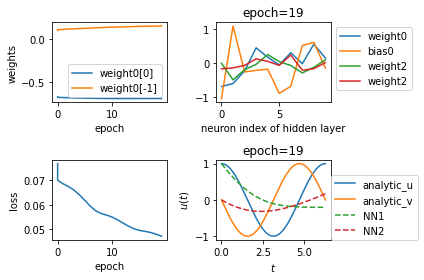

In [5]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
epochList = []; w1List = []; w2List = []; lossList = [];

def animate(epoch):
    # Zero-out the gradient buffers
    adam.zero_grad()
    # Evaluate the loss
    l = loss(t)
    # Calculate the gradients
    l.backward()
    # Update the network
    adam.step()
    
    weight0 = list(NN[0].parameters())[0];weight0 = weight0.detach().numpy();
    bias0 = list(NN[0].parameters())[1];bias0 = bias0.detach().numpy();
    weight2 = list(NN[2].parameters())[0];weight2 = weight2.detach().numpy();
    
    epochList.append(epoch)
    w1List.append(float(weight0[0]))
    w2List.append(float(weight0[-1]))
    lossList.append(float(l))

    uvNN1 = UV(torch.Tensor(tspan)).detach().numpy()[0]
    uvNN2 = UV(torch.Tensor(tspan)).detach().numpy()[1]


    ax1.clear()# hold off
    line1,=ax1.plot(epochList,w1List,label="weight0[0]");
    line1,=ax1.plot(epochList,w2List,label="weight0[-1]");
    ax1.legend();ax1.set_xlabel('epoch');ax1.set_ylabel('weights')

    ax2.clear()# hold off
    line2,=ax2.plot(weight0,label='weight0');ax2.plot(bias0,label='bias0');ax2.plot(weight2.T,label='weight2');
    ax2.set_title(f"epoch={epoch}");ax2.set_xlabel('neuron index of hidden layer');
    ax2.legend(bbox_to_anchor=(1, 1))# ax2.legend(loc='best')

    ax3.clear()# hold off
    line3, = ax3.plot(epochList, lossList)#line3, = ax3.semilogy(epochList, lossList1)
    
    ax3.set_xlabel('epoch');ax3.set_ylabel('loss');

    ax4.clear()# hold off
    ax4.set_title(f"epoch={epoch}");ax4.set_xlabel('$t$');ax4.set_ylabel('$u(t)$');
    line4,=ax4.plot(tspan,uA,label='analytic_u')
    line4,=ax4.plot(tspan,-vA,label='analytic_v')
    ax4.plot(tspan,uvNN1,'--',label='NN1')
    ax4.plot(tspan,uvNN2,'--',label='NN2')
#    ax4.plot(t.repeat(1, 2).detach().numpy(),UV(torch.Tensor(t)).T.detach().numpy(), 'r.')# (t,uNN)采样点
    ax4.legend(bbox_to_anchor=(1, 0), loc=3, borderaxespad=0)
    
    plt.tight_layout()#否则图部分遮住
    return line1,line2,line3,line4
    
epochs = 20
ani = animation.FuncAnimation(fig, animate, frames = epochs, interval=200, repeat=False, blit=True)
HTML(ani.to_jshtml())

In [6]:
#just call function ani can print the animation, but just change the epochs at one time
#put epoch into animation
#epochs = 50
ani = animation.FuncAnimation(fig, animate, frames = 50, interval=200, repeat=False, blit=True)
HTML(ani.to_jshtml())

<Figure size 432x288 with 0 Axes>

In [7]:
ani = animation.FuncAnimation(fig, animate, frames = 100, interval=200, repeat=False, blit=True)
HTML(ani.to_jshtml())

<Figure size 432x288 with 0 Axes>

In [8]:
ani = animation.FuncAnimation(fig, animate, frames = epochs = 10, interval=200, repeat=False, blit=True)
HTML(ani.to_jshtml())

SyntaxError: invalid syntax (2703751673.py, line 1)

Since animation is a fixed function with fixed parameters, like frames which is exactly one of our hyperparameters epochs, so we can just call the ani in one line with changable epochs. However, it might be difficult to add other hyperparameters in animation function. Otherwise, if we want to add all of the code together, I guess we need to define one hyperparameters funcion inside the animation function, it is very complex in my opinion.<br>
However, I can set a model function to call without animation.

In [54]:
##give up animation function
epochList = []; w1List = []; w2List = []; lossList = [];
#tspan = np.linspace(0, 2*np.pi, 500)[:, None]


def model(neurons=10, batchsize=500, learnrate=0.01, epochs=20, tspan = np.linspace(0, 2*np.pi, 500)[:, None], t=torch.linspace(0, 2*np.pi, batchsize).reshape(-1,1)):
#    t=torch.linspace(0, 2*np.pi, batchsize).reshape(-1,1)
    NN = nn.Sequential(nn.Linear(1, neurons), nn.Sigmoid(), nn.Linear(neurons, 2, bias=False))
    adam = torch.optim.Adam(NN.parameters(), lr=learnrate)
    uA = np.cos(tspan)
    vA = np.sin(tspan)
    UV = lambda t: uvo + (t* NN(t)).mT
    f = lambda t: torch.matmul(torch.tensor([[0,1],[-1,0]],dtype=torch.float), UV(t))

    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
 
    for epoch in range(epochs):
        adam.zero_grad()
        t.requires_grad_(True)
        UVot=UV(t)
        duvdt1=torch.autograd.grad(UVot[0].T,t,grad_outputs=torch.ones_like(UVot[0].T), create_graph=True)[0]
        duvdt2=torch.autograd.grad(UVot[1].T,t,grad_outputs=torch.ones_like(UVot[1].T), create_graph=True)[0]
        l = torch.mean((torch.cat([duvdt1, duvdt2], 1)-f(t).T)**2)
        l.backward(retain_graph=True)
#        torch.autograd.set_detect_anomaly(True)
        adam.step()
    
        weight0 = list(NN[0].parameters())[0];weight0 = weight0.detach().numpy();
        bias0 = list(NN[0].parameters())[1];bias0 = bias0.detach().numpy();
        weight2 = list(NN[2].parameters())[0];weight2 = weight2.detach().numpy();
    
        epochList.append(epoch)
        w1List.append(float(weight0[0]))
        w2List.append(float(weight0[-1]))
        lossList.append(float(l))

        uvNN1 = UV(torch.Tensor(tspan)).detach().numpy()[0]
        uvNN2 = UV(torch.Tensor(tspan)).detach().numpy()[1]


        ax1.clear()# hold off
        line1,=ax1.plot(epochList,w1List,label="weight0[0]");
        line1,=ax1.plot(epochList,w2List,label="weight0[-1]");
        ax1.legend();ax1.set_xlabel('epoch');ax1.set_ylabel('weights')

        ax2.clear()# hold off
        line2,=ax2.plot(weight0,label='weight0');ax2.plot(bias0,label='bias0');ax2.plot(weight2.T,label='weight2');
        ax2.set_title(f"epoch={epoch}");ax2.set_xlabel('neuron index of hidden layer');
        ax2.legend(bbox_to_anchor=(1, 1))# ax2.legend(loc='best')

        ax3.clear()# hold off
        line3, = ax3.plot(epochList, lossList)#line3, = ax3.semilogy(epochList, lossList1)
    
        ax3.set_xlabel('epoch');ax3.set_ylabel('loss');

        ax4.clear()# hold off
        ax4.set_title(f"epoch={epoch}");ax4.set_xlabel('$t$');ax4.set_ylabel('$u(t)$');
        line4,=ax4.plot(tspan,uA,label='analytic_u')
        line4,=ax4.plot(tspan,-vA,label='analytic_v')
        ax4.plot(tspan,uvNN1,'--',label='NN1')
        ax4.plot(tspan,uvNN2,'--',label='NN2')

        ax4.legend(bbox_to_anchor=(1, 0), loc=3, borderaxespad=0)
    
        plt.tight_layout()#否则图部分遮住
        plt.savefig("aa.png")
    return line1,line2,line3,line4

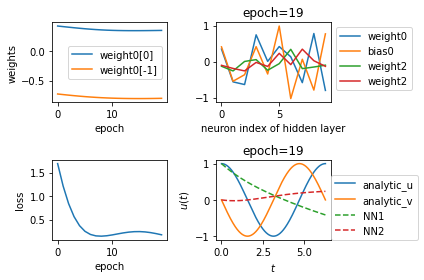

In [50]:
p = model(neurons=10, batchsize=500, learnrate=0.01, epochs=20, tspan = np.linspace(0, 2*np.pi, 500)[:, None], t=torch.linspace(0, 2*np.pi, batchsize).reshape(-1,1))

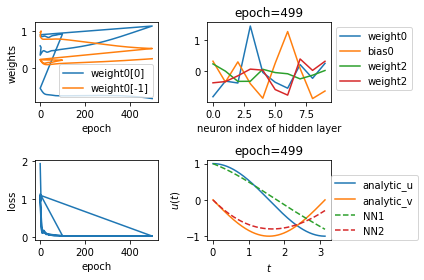

In [58]:
p = model(neurons=10, batchsize=500, learnrate=0.01, epochs=500, tspan = np.linspace(0, np.pi, 500)[:, None], t=torch.linspace(0, np.pi, batchsize).reshape(-1,1))
#plt.savefig("aa.png")